In [1]:
pdf_path = "data/Правила записи иа первичный прием, ЦПК ФТС.pdf"
high_quality = True

## ENVIRONMENT

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
api = os.getenv("api")

## PDF Preprocessing

In [3]:
import hashlib
import pdfplumber
import os

def get_file_hash(filepath):
    """Вычисляет SHA256-хэш файла и возвращает первые 16 символов."""
    hash_sha256 = hashlib.sha256()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_sha256.update(chunk)
    return hash_sha256.hexdigest()[:16]

def pdf_to_images(pdf_path, resolution=300):
    """
    Конвертирует все страницы PDF в изображения.

    Аргументы:
        pdf_path (str): путь к PDF файлу
        resolution (int): DPI для рендера страниц

    Возвращает:
        (pdf_id, image_paths) где
        pdf_id (str): уникальный id для папки (хэш файла)
        image_paths (list[str]): список путей к сохранённым изображениям
    """
    pdf_id = get_file_hash(pdf_path)
    output_dir = f"images/{pdf_id}"
    os.makedirs(output_dir, exist_ok=True)

    image_paths = []

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            im = page.to_image(resolution=resolution)
            img_filename = f"{output_dir}/page{page_num}.png"
            im.save(img_filename, format="PNG")
            image_paths.append(img_filename)

    return pdf_id, image_paths

# пример вызова
pdf_id, image_paths = pdf_to_images(pdf_path)
print(pdf_id)

35dc654167750d77


## Processing

In [4]:
prompt = f"""
You are a professional comic storyboard writer. 
Your task is to transform a given sequence of **images** (possibly from parsed PDFs with mixed pictures and captions) into a cinematic comic script.

LANGUAGE & VISIBLE TEXT (VERY IMPORTANT):
- All dialogue, narration, labels, signage, UI, stamps, documents, and SFX **must be in English only**.
- Translate any non-English text from the source images into natural English. Do NOT use transliteration or Cyrillic.
- Use only ASCII letters A–Z, digits, and standard punctuation for any quoted visible text.
- Avoid mixed languages, non-English diacritics, and random character noise.
- When visible text should appear in a panel, write it explicitly inside the description, e.g.:
  Text on sign: "CITY HALL". Stamp: "APPROVED". SFX: "CLACK".
- For proper nouns originally non-English, choose a consistent English form (e.g., "Moscow City Court") and use it throughout.

Instructions:
1. Carefully **describe each image** in English (visual content, characters, actions, mood, setting).
2. Extract the main ideas and convert them into a sequence of **comic pages**, each page having exactly **4 panels** (so every page = 1 scene = 4 panels).
3. Write everything in **English**.
4. Output must be strictly in the following format (Python tuple):
(
    "Unified cinematic style for the entire series: [one single descriptive paragraph describing art style, characters, settings, rendering details, coloring, film look, and atmosphere that apply to the entire comic].",
    [
        "COMIC_SCENE_01_NAME — 4-panel comic page. Panel 1: [description derived from the images]. Bubble: [dialogue]. Panel 2: [description]. Bubble: [dialogue]. Panel 3: [description]. Bubble: [dialogue]. Panel 4: [description]. Bubble: [dialogue].",
        "COMIC_SCENE_02_NAME — 4-panel comic page, direct continuation. Panel 1: [description]. Bubble: [dialogue]. Panel 2: [description]. Bubble: [dialogue]. Panel 3: [description]. Bubble: [dialogue]. Panel 4: [description]. Bubble: [dialogue].",
        ...
    ]
)

Rules:
- Do not include any extra variables or explanations (no `unified_style_en = ...`, no `slides = ...`). Only return the tuple above.
- Replace any literal foreign/legal text with **visual narrative and natural English dialogue** between characters.
- Ensure dialogue is simple, conversational, and in English.
- Maintain continuity: the same characters should appear across panels and scenes, with consistent roles and personalities.
- Each scene = exactly one 4-panel comic page.
- Maximum 3 comic scenes per run (12 panels total).
- Output must be valid Python (tuple of a string + list of strings), parsable with `ast.literal_eval`.
- Final self-check: ensure there are **no non-English characters** anywhere in the tuple; if any appear, replace with correct English.

---
SOURCE IMAGES:
"""

In [5]:
import os
import base64
import mimetypes
from openai import OpenAI

def images_to_message(paths, prompt):
    if isinstance(paths, str):
        paths = [paths]
    
    content = [{"type": "text", "text": prompt}]
    
    for path in paths:
        # Определяем MIME тип (по расширению)
        mime_type, _ = mimetypes.guess_type(path)
        if mime_type is None:
            mime_type = "image/png"  # дефолт
        
        with open(path, "rb") as f:
            image_bytes = f.read()
            image_base64 = base64.b64encode(image_bytes).decode("utf-8")
        
        data_url = f"data:{mime_type};base64,{image_base64}"
        content.append({"type": "image_url", "image_url": {"url": data_url}})
    
    return {"role": "user", "content": content}


client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api,
)

message = images_to_message(
    image_paths, 
    prompt
)

In [6]:
import ast
import re

def extract_comic_tuple(text: str):
    """
    Извлекает первый валидный Python-кортеж из ответа модели,
    даже если вокруг есть лишний текст.
    """
    # Находим участок от первой открывающей "(" до последней закрывающей ")"
    match = re.search(r"\(.*\)", text, re.DOTALL)
    if not match:
        raise ValueError("Не найден кортеж в ответе модели.")
    
    tuple_str = match.group(0)

    try:
        parsed = ast.literal_eval(tuple_str)
    except Exception as e:
        raise ValueError(f"Ошибка при парсинге кортежа: {e}\nИсходный текст:\n{tuple_str}")
    
    # Проверим, что структура правильная
    if not (isinstance(parsed, tuple) and len(parsed) == 2):
        raise ValueError("Найденный объект не является кортежем из 2 элементов.")
    if not isinstance(parsed[0], str):
        raise ValueError("Первый элемент кортежа должен быть строкой (unified_style).")
    if not isinstance(parsed[1], list):
        raise ValueError("Второй элемент кортежа должен быть списком (slides).")
    
    return parsed

while True:
    try:
        completion = client.chat.completions.create(
            model=("openai/gpt-5-nano" if not high_quality else "openai/gpt-5"),
            messages=[message],
        )
        llm_output = completion.choices[0].message.content
        unified_style, slides = extract_comic_tuple(llm_output)
    except Exception as e:
        print(e)
        continue
    else:
        break

text_slides = " ".join(slides)
print("Unified style:\n", unified_style)
print("\nSlides:")
for i, scene in enumerate(slides, 1):
    print(f"\nScene {i}:\n{scene}")

Unified style:
 Unified cinematic style for the entire series: Clean line art with soft shading and a restrained hospital palette of whites, mint greens, and pale grays. Establishing shots of a modern public clinic transition to intimate over-the-shoulder views at the registration window and close-ups of forms, phones, and signage. Characters are naturalistic with calm expressions; lighting is cool and even like fluorescent ceiling lights. Textures use subtle halftone with thin black outlines; diegetic English labels on posters and screens are crisp. Occasional SFX like 'CLACK' or 'BEEP' punctuate the quiet. The tone is procedural and reassuring, framed like a steady documentary camera.

Slides:

Scene 1:
FIRST VISIT - 4-panel comic page. Panel 1: In a bright clinic lobby, a poster is pinned beside the registration window. Text on poster: "Central Polyclinic of FTS - Rules for First Appointment. Hours: Mon-Fri 08:00-20:00; Sat 09:00-14:00." A round stamp reads: "APPROVED". Bubble: "Ale

## Generating

ERROR:root:Нет контента в choice: Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None, images=[{'type': 'image_url', 'image_url': {'url': ''}, 'index': 0}]), native_finish_reason='STOP')

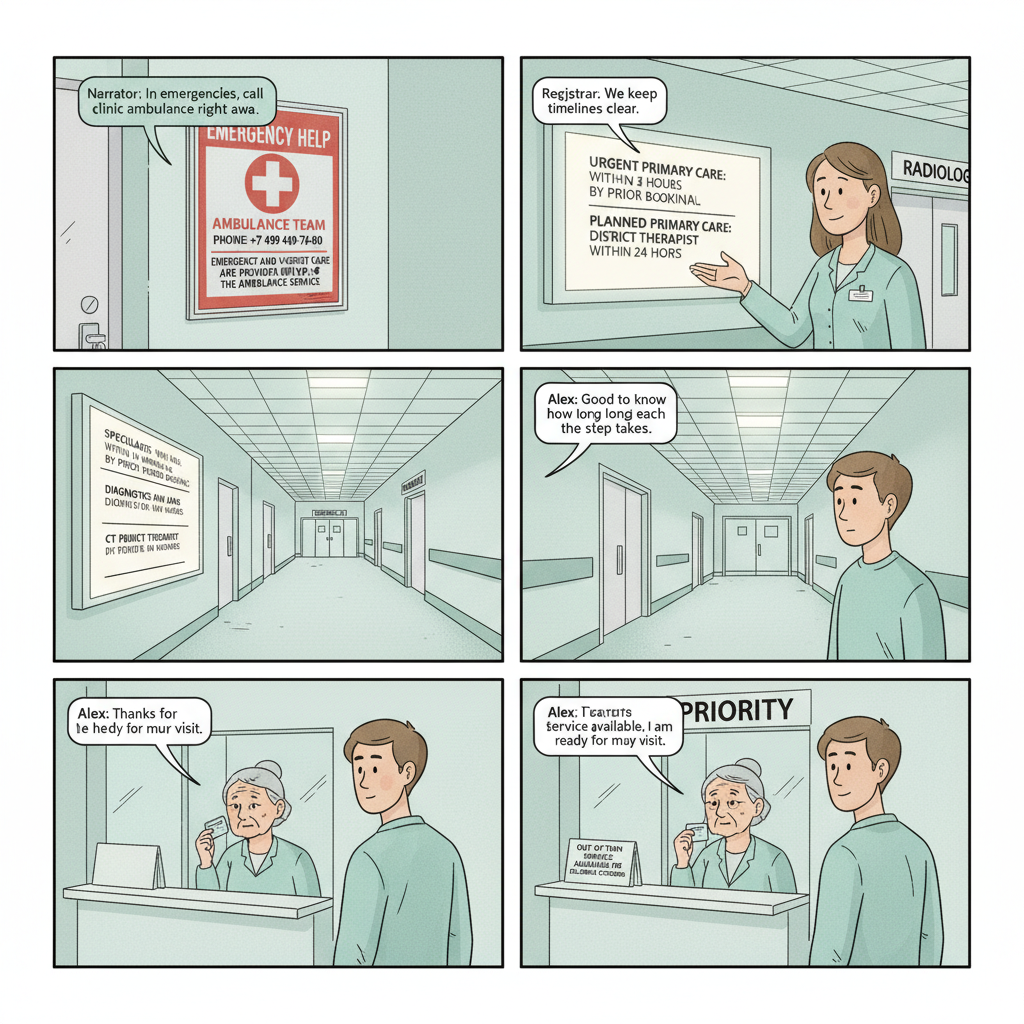

In [9]:
import time
import json
import base64
import logging
import requests
from pathlib import Path
from openai import OpenAI
import os

def fix_base64_padding(b64_string):
    """Добавляет недостающие символы '=' для корректной декодировки base64."""
    b64_string = b64_string.strip()
    # Удаляем все пробелы и переносы строк
    b64_string = b64_string.replace('\n', '').replace('\r', '').replace(' ', '')
    missing_padding = len(b64_string) % 4
    if missing_padding:
        b64_string += '=' * (4 - missing_padding)
    return b64_string

class OpenRouterImageAPI:
    def __init__(self, api_key, model=None, size=None):
        default_headers = {}
        if os.getenv("OPENROUTER_HTTP_REFERER"):
            default_headers["HTTP-Referer"] = os.getenv("OPENROUTER_HTTP_REFERER")
        if os.getenv("OPENROUTER_X_TITLE"):
            default_headers["X-Title"] = os.getenv("OPENROUTER_X_TITLE")

        self.client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=api_key,
            default_headers=default_headers or None,
        )

        # Для ручного HTTP fallback
        self.api_key = api_key
        self.default_headers = default_headers or None

        # Используем модель, поддерживающую вывод изображений
        self.model = model or os.getenv("OPENROUTER_IMAGE_MODEL", "google/gemini-2.5-flash-image-preview")
        self.size = size or os.getenv("OPENROUTER_IMAGE_SIZE", "1024x1024")

    def generate_image(self, prompt, num_images=1, output_dir="outputs", prefix="slide"):
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        logging.info(f"Генерируем изображение через OpenRouter model='{self.model}' size='{self.size}'")

        resp = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            extra_body={
                "modalities": ["image", "text"],
                "n": num_images,
                "size": self.size,
                "response_format": "b64_json"
            }
        )

        saved_paths = []
        timestamp = int(time.time())

        image_counter = 0
        for i, choice in enumerate(resp.choices, start=1):
            content = getattr(choice.message, "content", None)
            if not content:
                logging.error(f"Нет контента в choice: {choice}")
                continue

            # Приводим к списку блоков
            blocks = content if isinstance(content, list) else [content]

            for block in blocks:
                b64 = None
                url_to_fetch = None

                if isinstance(block, dict):
                    btype = block.get("type") or block.get("kind")
                    # OpenRouter 'output_image' (наиболее часто)
                    if btype in ("output_image", "image"):
                        b64 = block.get("image_base64") or block.get("b64_json")
                        # Некоторые провайдеры вкладывают глубже
                        if not b64 and isinstance(block.get("image"), dict):
                            b64 = block["image"].get("b64_json") or block["image"].get("base64")
                    # Старый обработчик data URLs
                    if btype == "image_url" and isinstance(block.get("image_url"), dict):
                        img_url = block["image_url"].get("url", "")
                        if isinstance(img_url, str) and img_url.startswith("data:"):
                            try:
                                _, b64 = img_url.split(",", 1)
                            except Exception:
                                b64 = None
                        elif isinstance(img_url, str) and img_url.startswith("http"):
                            url_to_fetch = img_url
                elif isinstance(block, str):
                    text = block.strip()
                    if text.startswith("data:"):
                        try:
                            _, b64 = text.split(",", 1)
                        except Exception:
                            b64 = None
                    else:
                        # Эвристика: длинные строки считаем base64
                        if len(text) > 100:
                            b64 = text

                # Сохраняем из base64, если есть
                if b64:
                    try:
                        b64_fixed = fix_base64_padding(b64)
                        image_bytes = base64.b64decode(b64_fixed)
                        image_counter += 1
                        file_path = Path(output_dir) / f"{prefix}-{timestamp}-{image_counter}.png"
                        with open(file_path, "wb") as f:
                            f.write(image_bytes)
                        saved_paths.append(str(file_path))
                    except Exception as e:
                        logging.error(f"Ошибка при декодировании/сохранении base64 изображения: {e}")
                        continue

                # Фоллбек: скачиваем по URL, если есть
                if url_to_fetch:
                    try:
                        r = requests.get(url_to_fetch, timeout=60)
                        r.raise_for_status()
                        image_counter += 1
                        file_path = Path(output_dir) / f"{prefix}-{timestamp}-{image_counter}.png"
                        with open(file_path, "wb") as f:
                            f.write(r.content)
                        saved_paths.append(str(file_path))
                    except Exception as e:
                        logging.error(f"Ошибка при скачивании изображения по URL: {e}")
                        continue

        if not saved_paths:
            # Глубокий фоллбек: сканируем весь объект ответа на base64 строки
            try:
                def walk_collect_b64(value, out_list):
                    if isinstance(value, dict):
                        for k, v in value.items():
                            # Часто используемые ключи
                            if k in ("image_base64", "b64_json", "imageBytes", "image_base64_png") and isinstance(v, str):
                                out_list.append(v)
                            # Любые поля URL с data URL
                            if k in ("url", "image_url") and isinstance(v, str) and v.startswith("data:"):
                                try:
                                    _, b = v.split(",", 1)
                                    out_list.append(b)
                                except Exception:
                                    pass
                            else:
                                walk_collect_b64(v, out_list)
                    elif isinstance(value, list):
                        for item in value:
                            walk_collect_b64(item, out_list)
                    elif isinstance(value, str):
                        text = value.strip()
                        if text.startswith("data:") and "," in text:
                            try:
                                _, b = text.split(",", 1)
                                out_list.append(b)
                            except Exception:
                                pass
                        else:
                            # Эвристика: очень длинные base64-подобные строки
                            if len(text) > 500 and all(c.isalnum() or c in "+/=\n\r" for c in text[:100]):
                                out_list.append(text)

                raw_obj = None
                try:
                    raw_obj = resp.model_dump()
                except Exception:
                    try:
                        raw_json = getattr(resp, "json", None)
                        if callable(raw_json):
                            raw_obj = raw_json()
                        else:
                            raw_obj = json.loads(str(resp))
                    except Exception:
                        raw_obj = None

                candidates = []
                if raw_obj is not None:
                    walk_collect_b64(raw_obj, candidates)

                for idx, b64 in enumerate(candidates, start=1):
                    try:
                        b64_fixed = fix_base64_padding(b64)
                        image_bytes = base64.b64decode(b64_fixed)
                        file_path = Path(output_dir) / f"{prefix}-{timestamp}-fallback-{idx}.png"
                        with open(file_path, "wb") as f:
                            f.write(image_bytes)
                        saved_paths.append(str(file_path))
                    except Exception:
                        continue
            except Exception as e:
                logging.debug(f"Ошибка при сканировании фоллбека: {e}")

        # Финальный фоллбек: прямой HTTP-запрос к OpenRouter
        if not saved_paths:
            try:
                headers = {
                    "Authorization": f"Bearer {self.api_key}",
                    "Content-Type": "application/json",
                }
                if self.default_headers:
                    headers.update(self.default_headers)
                body = {
                    "model": self.model,
                    "messages": [{"role": "user", "content": prompt}],
                    "modalities": ["image", "text"],
                    "n": num_images,
                    "size": self.size,
                    "response_format": "b64_json",
                }
                http_resp = requests.post(
                    "https://openrouter.ai/api/v1/chat/completions",
                    headers=headers,
                    json=body,
                    timeout=120,
                )
                http_resp.raise_for_status()
                data = http_resp.json()

                # Повторно используем сборщик
                candidates = []
                def walk_collect_b64_http(value, out_list):
                    if isinstance(value, dict):
                        for k, v in value.items():
                            if k in ("image_base64", "b64_json", "imageBytes", "image_base64_png") and isinstance(v, str):
                                out_list.append(v)
                            if k in ("url", "image_url") and isinstance(v, str) and v.startswith("data:"):
                                try:
                                    _, b = v.split(",", 1)
                                    out_list.append(b)
                                except Exception:
                                    pass
                            else:
                                walk_collect_b64_http(v, out_list)
                    elif isinstance(value, list):
                        for item in value:
                            walk_collect_b64_http(item, out_list)
                    elif isinstance(value, str):
                        text = value.strip()
                        if text.startswith("data:") and "," in text:
                            try:
                                _, b = text.split(",", 1)
                                out_list.append(b)
                            except Exception:
                                pass
                        elif len(text) > 500 and all(c.isalnum() or c in "+/=\n\r" for c in text[:100]):
                            out_list.append(text)

                walk_collect_b64_http(data, candidates)

                for idx, b64 in enumerate(candidates, start=1):
                    try:
                        b64_fixed = fix_base64_padding(b64)
                        image_bytes = base64.b64decode(b64_fixed)
                        file_path = Path(output_dir) / f"{prefix}-{timestamp}-http-{idx}.png"
                        with open(file_path, "wb") as f:
                            f.write(image_bytes)
                        saved_paths.append(str(file_path))
                    except Exception:
                        continue
            except Exception as e:
                logging.error(f"HTTP fallback не удался: {e}")

        if not saved_paths:
            # Регулярное выражение для поиска base64 в любом текстовом представлении
            try:
                import re
                def extract_and_save_from_text(text: str, tag: str):
                    local_saved = []
                    if not text:
                        return local_saved
                    # data URL pattern
                    for m in re.finditer(r"data:image/[^;]+;base64,([A-Za-z0-9+/=\r\n]+)", text):
                        b64 = m.group(1)
                        try:
                            b64_fixed = fix_base64_padding(b64)
                            image_bytes = base64.b64decode(b64_fixed)
                            file_path = Path(output_dir) / f"{prefix}-{timestamp}-scan-{tag}-{len(local_saved)+1}.png"
                            with open(file_path, "wb") as f:
                                f.write(image_bytes)
                            local_saved.append(str(file_path))
                        except Exception:
                            continue
                    # Generic long base64 chunks (PNG/JPEG часто начинаются с iVBOR или /9j/)
                    for m in re.finditer(r"(iVBOR|/9j/)[A-Za-z0-9+/=\r\n]{400,}", text):
                        b64 = m.group(0)
                        try:
                            b64_fixed = fix_base64_padding(b64)
                            image_bytes = base64.b64decode(b64_fixed)
                            file_path = Path(output_dir) / f"{prefix}-{timestamp}-scan-{tag}-{len(local_saved)+1}.png"
                            with open(file_path, "wb") as f:
                                f.write(image_bytes)
                            local_saved.append(str(file_path))
                        except Exception:
                            continue
                    return local_saved

                text_repr = None
                try:
                    text_repr = resp.model_dump_json()  # может не содержать большие блобы
                except Exception:
                    text_repr = str(resp)
                saved_paths.extend(extract_and_save_from_text(text_repr, "obj"))
            except Exception:
                pass

        if not saved_paths:
            raise Exception("Генерация изображения не вернула ни одного изображения")

        return saved_paths


client = OpenRouterImageAPI(api, model="google/gemini-2.5-flash-image-preview")
Path(f"outputs/{pdf_id}").mkdir(parents=True, exist_ok=True)
full_prompt = f"{unified_style} {text_slides}"
try:
    saved = client.generate_image(full_prompt, num_images=1, output_dir=f"outputs/{pdf_id}", prefix=f"slide-{i}")
except Exception as e:
    pass